In [1]:
import json
from urllib.error import HTTPError
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from time import sleep
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [2]:
class_name = re.compile('mw-category.*') # для поиска категорий на странице по тегу

def get_links(url):

    links = []
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        categories_list = soup.find(class_=class_name)
        categories = categories_list.find_all('a', href=True)
        for category in categories:
            links.append('https://it.wikipedia.org/' + category.get('href'))
    except HTTPError as e:
        return None
    return links

In [3]:
#берется 10 категорий,потому что долго выполняется для всех 174
all_links=[]
url='https://it.wikipedia.org/wiki/Categoria:Automobili_per_marca'
array_categories= get_links(url)
sub_links=[]
for i in array_categories[0:10]:
    sub_links.extend(get_links(i))
print("sublinks extracted")
def get_next(sub_link):
    for elem in sub_link:
        if 'Categoria' in elem:
            sub=get_links(elem)
            sub_links.extend(sub)
            get_next(sub)

sublinks extracted


In [4]:
get_next(sub_links)
print("all the links extracted ",len(sub_links))
headers = ["Car","Lunghezza","Larghezza","Altezza","Passo","Massa"]
dest_file = r'dat.csv'
cars = []
data = []
all_data = {}
for sub in sub_links:
    try:
        html_content = requests.get(sub).text
        soup = BeautifulSoup(html_content, 'lxml')
        table = soup.find("table", attrs={"class": "sinottico"})
        table_data = table.tbody.find_all("tr")
        cars.append(table_data[0].th.text.strip())
        t_row = {}
        for tr in table_data:
            for td, th in zip(tr.find_all("td"),tr.find_all("th")):
                if th.text.strip() in headers:
                    col=re.search("^[^\d]*?(\d+)",td.text.replace('\n', '').strip())
                    t_row[th.text.strip()] = col.group(1)
        all_data[table_data[0].th.text.strip()]=t_row
        with open('data.json','w') as  fp:
              json.dump(all_data,fp,indent=4,sort_keys=True)
    except:
        captcha=5
        sleep(captcha)
        captcha += 1
print("extract done")

all the links extracted  223
extract done


In [5]:
with open('data.json','r') as f:
     data=json.load(f)
df=pd.DataFrame(data)
df=pd.DataFrame(df.transpose())
#df = df['Car', 5,4,3,2,1]
df.reset_index(inplace=True)
df.rename(columns={'index': 'Car'},inplace=True)

In [6]:
df=df.astype({'Larghezza': 'float64' ,'Lunghezza':'float64','Massa':'float64','Passo':'float64','Altezza':'float64'})

In [7]:
df.to_csv('dat.csv',mode='w',index=False)

                                        Car  Larghezza
97      Alfa Romeo Disco Volante by Touring     2032.0
196  Touring SuperleggeraDisco Volante 2012     2020.0
38                                Acura ZDX     1994.0
132                     Alfa Romeo Scighera     1981.0
17                                AMC Pacer     1963.0
18                                AMC Rebel     1963.0
138                          Alfa Romeo TZ3     1944.0
127                      Alfa Romeo Pandion     1940.0
114                       Alfa Romeo Gloria     1910.0
137                      Alfa Romeo Stelvio     1903.0


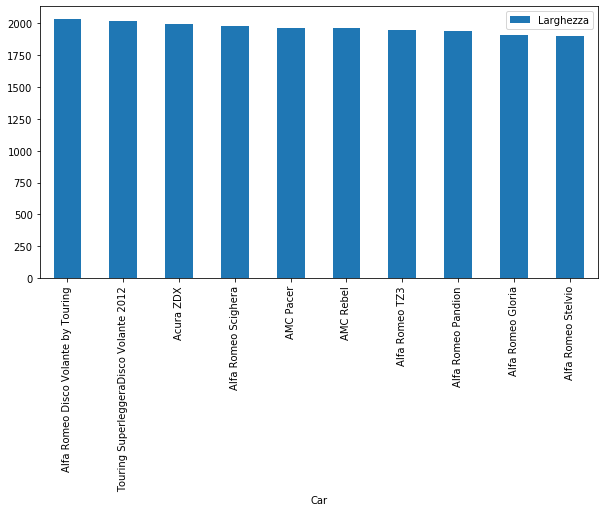

In [9]:
#1The 10  widest cars
df1=df.sort_values('Larghezza',ascending=False).filter(['Car','Larghezza']).dropna().head(10)
print(df1)
df1.plot(figsize=(10,5),kind='bar',x='Car',y='Larghezza')


In [63]:
# 2.the division by massa and  percentage of cars with Lunghezza>2500 and <2500  in each group
def massa_div(x):
    if x>=0.0 and x <500.0:
        return 'less than 500'
    elif x>=500.0 and x<1000.0:
         return 'from 500 to 1000' 
    elif x>=1000.0 and x<1500.0:
        return 'from 1000 to 1500'
    elif x>=1500.0 and x<2000.0:
        return 'from 1500 to 2000'

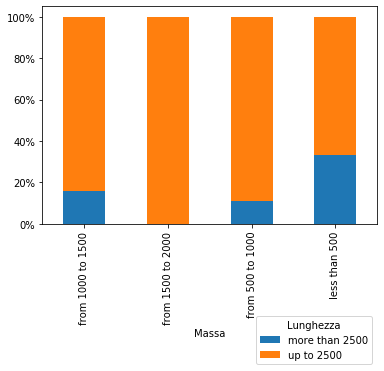

In [95]:
df1=df.groupby([df['Massa'].apply(massa_div),df['Lunghezza']\
            .apply(lambda x: "up to 2500" if x>2500.0 else "more than 2500")]).size().groupby(level=0)\
.apply(lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True,legend=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax=plt.gca()
ax.get_legend().set_bbox_to_anchor((.9999,-0.4))
plt.show()

Car
AC         1114.000000
ALFA        972.000000
AMC        1335.125000
Abarth      875.625000
Alfa       1112.920635
Alpine      878.285714
Amilcar     786.538462
Ascari     1315.000000
Fiat        913.333333
Name: Massa, dtype: float64

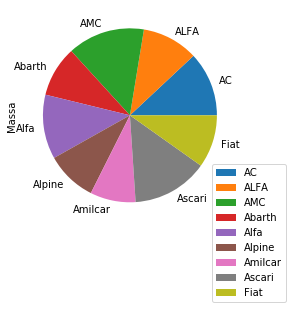

In [71]:
#3. The average massa by car categorie
df1=df[(df['Massa']!=0)].groupby(df['Car'].apply(lambda x: x.split()[0].strip() if x else None))['Massa'].mean().dropna()
df1.plot(kind='pie',legend=True)
ax=plt.gca()
ax.get_legend().set_bbox_to_anchor((.8532,.3))
df1

In [115]:
#4. the largest cars by habarites

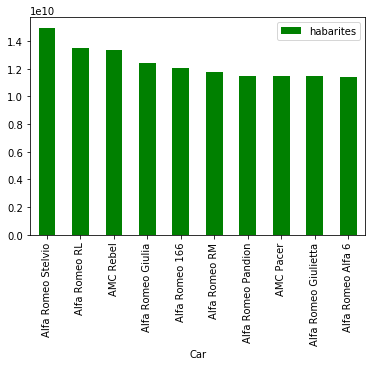

In [240]:
from matplotlib import cm
df['habarites']=df.dropna().apply(lambda row: "{:.1f}".format(row.Lunghezza*row.Larghezza*row.Altezza),axis=1).astype('float')
df1=df.sort_values(by='habarites',ascending=False).head(10)
cmap = cm.get_cmap('Spectral')
df1.plot(kind='bar',y='habarites',x='Car',color='g')
